In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss, auc, roc_curve, roc_auc_score, accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
%matplotlib inline

In [24]:
##Load data for final model
data = pd.read_csv('../ult_sign_scrape/race_master/master_database_fe4.csv')

In [25]:
##Clean data by dropping extraneous columns
cleaned_data = data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
##Second stage of cleaning by removing na values from dataframe
cleaned_data = cleaned_data.dropna()

In [26]:
##Create gender dummy variables for model
gender_dummies = pd.get_dummies(cleaned_data.gender, prefix='gender')
cleaned_data = cleaned_data.join(gender_dummies)

In [27]:
##Consolidate all starts (code DNF with finishers) for modeling
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded
 
print 'Before Coding:'
print pd.value_counts(cleaned_data["status"])
cleaned_data["status_coded"] = coding(cleaned_data["status"], {'1':1,'2':1, '3':0})
print '\nAfter Coding:'
print pd.value_counts(cleaned_data["status_coded"])
status_coded = cleaned_data.drop(['status'], axis=1)

Before Coding:
1    6291
2    3930
3     540
Name: status, dtype: int64

After Coding:
1    10221
0      540
Name: status_coded, dtype: int64


In [28]:
##Set response variable for coded dataframe
y_DNS = status_coded.pop('status_coded')
##Set response variable for uncoded dataframe
y_DNF = cleaned_data.pop('status')

In [29]:
##Set predictors for coded dataframe
codedX = status_coded.drop(['gender', 'participant_id', 'race_name', 'race_id', 'Age_Rank', \
                  'Gender_Rank', 'Total_races'\
                 , 'gender_M'], axis=1)
##Set predictors for uncoded dataframe
uncodedX = cleaned_data.drop(['gender', 'participant_id', 'race_name', 'race_id', 'Age_Rank', \
                  'Gender_Rank', 'Total_races'\
                 , 'gender_M'], axis=1)

In [30]:
##Create test/train splits for both datasets
##coded dataframe
cX_train, cX_test, cy_train, cy_test = train_test_split(codedX, y_DNS, test_size=0.3)
##uncoded dataframe
uX_train, uX_test, uy_train, uy_test = train_test_split(uncodedX, y_DNF, test_size=0.3)

# Logistic Regression Modeling

In [42]:
##coded dataframe
cLR = LR(C=10)
cLR.fit(cX_train, cy_train)
cLRp = cLR.predict_proba(cX_test)
print log_loss(cy_test, cLRp)
print roc_auc_score(cy_test, cLRp[:,1])

0.191067928831
0.617058880692


In [51]:
##uncoded dataframe
uLR = LR(C=10)
uLR.fit(uX_train, uy_train)
uLRp = uLR.predict_proba(uX_test)
uLRa = uLR.predict(uX_test)
print log_loss(uy_test, uLRp)
print accuracy_score(uy_test, uLRa)

0.590786228697
0.679467327346


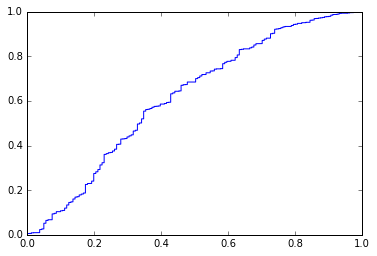

In [60]:
##ROC curve
fpr, tpr, thresholds = roc_curve(cy_test, cLRp[:,1]) 
plt.plot(fpr, tpr)
plt.show()

# Random Forest

In [55]:
##coded dataframe
cRF = RFC(n_estimators=500, criterion='entropy', random_state=1, n_jobs=2)
cRF.fit(cX_train, cy_train)
cRFp = cRF.predict_proba(cX_test)
print log_loss(cy_test, cRFp)
print roc_auc_score(cy_test, cRFp[:,1])

0.387330076575
0.750460574797


In [50]:
##uncoded dataframe
uRF = RFC(n_estimators=500, criterion='entropy', random_state=1, n_jobs=2)
uRF.fit(uX_train, uy_train)
uRFp = uRF.predict_proba(uX_test)
uRFa = uRF.predict(uX_test)
print log_loss(uy_test, uRFp)
print accuracy_score(uy_test, uRFa)

0.623020139247
0.702694332611


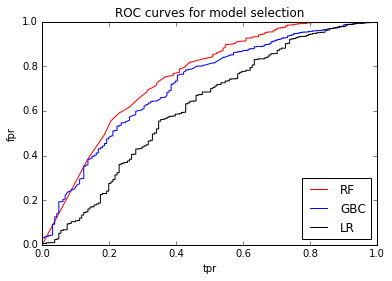

In [83]:
##ROC curve
fpr, tpr, thresholds = roc_curve(cy_test, cRFp[:,1]) 
labels = ['fpr', 'tpr']
RFP = plt.plot(fpr, tpr, 'r', label='Random Forest')
fpr, tpr, thresholds = roc_curve(cy_test, cGBCp[:,1]) 
GBCP = plt.plot(fpr, tpr, 'b', label='Gradient Boosted Classifier')
fpr, tpr, thresholds = roc_curve(cy_test, cLRp[:,1]) 
LRP = plt.plot(fpr, tpr, 'k', label='Logistic Regression')
plt.ylabel('fpr')
plt.xlabel('tpr')
plt.title('ROC curves for model selection')
plt.legend(['RF', 'GBC', 'LR'], loc=4)
plt.show()

In [53]:
##coded dataframe
cGBC = GBC(n_estimators=50, max_depth=4, learning_rate=0.1)
cGBC.fit(cX_train, cy_train)
cGBCp = cGBC.predict_proba(cX_test)
print log_loss(cy_test, cGBCp)
print roc_auc_score(cy_test, cGBCp[:,1])

0.183943583194
0.715731210573


In [49]:
##uncoded dataframe
uGBC = GBC(n_estimators=50, max_depth=4, learning_rate=0.1)
uGBC.fit(uX_train, uy_train)
uGBCp = uGBC.predict_proba(uX_test)
uGBCa = uGBC.predict(uX_test)
print log_loss(uy_test, uGBCp)
print accuracy_score(uy_test, uGBCa)

0.578134160046
0.689687209662


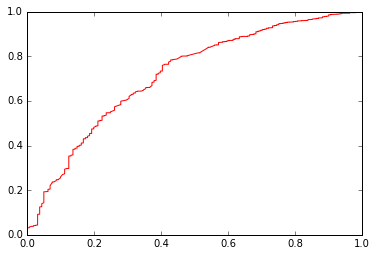

In [66]:
##ROC curve
fpr, tpr, thresholds = roc_curve(cy_test, cGBCp[:,1]) 
labels = ['fpr', 'tpr']
plt.plot(fpr, tpr, 'r')
plt.show()